# Spaceship Titanic Predictions

## Import the dataset

In [1]:
# Load libraries and dataset
import pandas as pd
df = pd.read_csv("train.csv")

# Function to impute mean or median based on skewness
def impute_with_mean_or_median(column):
    skewness = df[column].skew()
    if abs(skewness) > 1:
        median = df[column].median()
        return df[column].fillna(median)
    media = round(df[column].mean())
    return df[column].fillna(media)

# Function to impute mode based on the most frequent value
def mode_impute(column):
    moda_val = df[column].mode()[0]
    return df[column].fillna(moda_val)

# Binarize the booleans
df['CryoSleep'] = df['CryoSleep'].replace({False: 0, True: 1})
df['VIP'] = df['VIP'].replace({False: 0, True: 1})
df['Transported'] = df['Transported'].replace({False: 0, True: 1})

# I: Create new columns
# Passenger Id: Divide into group and passenger number
df[['GroupNum', 'PassNum']] = df['PassengerId'].str.split('_', expand=True)
df['GroupNum'] = pd.to_numeric(df['GroupNum'], errors='coerce')
df['PassNum'] = pd.to_numeric(df['PassNum'], errors='coerce')
df.drop(columns=["PassengerId"], inplace=True)
# TotalSpent: Total spent on amenities
df['TotalSpent'] = df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)
# Cabin column: Divide in three: Deck, CabinNumber, CabinSide
df[['Deck', 'CabinNumber', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)
df.drop(columns=["Cabin"], inplace=True)

# II: Label encoding for categorical data
df['HomePlanet'] = df['HomePlanet'].replace({'Earth': 0, 'Mars': 1, 'Europa': 2})                       # Label encode, ya que al utilizar one hot, la precisión disminuye
df['Destination'] = df['Destination'].replace({'TRAPPIST-1e': 0, '55 Cancri e': 1, 'PSO J318.5-22': 2}) # Label encode, ya que al utilizar one hot, la precisión disminuye
df['Deck'] = df['Deck'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7})       # Label encode, ya que al utilizar one hot, la precisión disminuye
df['CabinSide'] = df['CabinSide'].replace({'P': 0, 'S': 1})                                             # Label encode, ya que al utilizar one hot, la precisión disminuye

# III: Special cases for missing categorical values
# **Deck: (6 if HomePlanet == 0 and Deck is null)
df.loc[(df['HomePlanet'] == 0) & (df['Deck'].isnull()), 'Deck'] = 6             # Deck 6 is for passengers from Earth
# **CryoSleep: (0 if TotalSpent != 0)
df.loc[(df['TotalSpent'] > 0) & (df['CryoSleep'].isnull()), 'CryoSleep'] = 0    # If a passenger has spent money, then they did not use Cryosleep
# **VIP: If CryoSleep is 1 then 0, else impute mode
df.loc[(df['CryoSleep'] == 1) & (df['VIP'].isnull()), 'VIP'] = 0                # If a passenger is in Cryosleep, then they're not VIP

# IV: Impute categorical data with mode
df['HomePlanet'] = mode_impute('HomePlanet')
df['Destination'] = mode_impute('Destination')
df['Deck'] = mode_impute('Deck')
df['CabinSide'] = mode_impute('CabinSide')
df['CryoSleep'] = mode_impute('CryoSleep')
df['VIP'] = mode_impute('VIP')

# V: Create interaction columns
# HomePlanet-Destination: Bin the HomePlanet and Destination columns
df['HomePlanet_Destination_Interaction'] = df['HomePlanet'] * df['Destination']
# Deck-CabinSide: Bin the Deck and CabinSide columns


# VI: Special cases for missing numerical values
# **Amennities: (0 if CryoSleep == 1)
amenities = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
for amenity in amenities:
    df.loc[(df['CryoSleep'] == 1) & (df[amenity].isnull()), amenity] = 0 # If a passenger is in Cryosleep, then they did not use any amenities
# **Age: (6 if TotalSpent == 0)
df.loc[(df['TotalSpent'] == 0) & (df['Age'].isnull()), 'Age'] = 6 # If a passenger has not spent any money, then they're likely a child. 6 is the mean age of non-spdender children

# VII: Impute numerical data with mean or median
df['RoomService'] = impute_with_mean_or_median('RoomService')
df['FoodCourt'] = impute_with_mean_or_median('FoodCourt')
df['ShoppingMall'] = impute_with_mean_or_median('ShoppingMall')
df['Spa'] = impute_with_mean_or_median('Spa')
df['VRDeck'] = impute_with_mean_or_median('VRDeck')
df['CabinNumber'] = pd.to_numeric(df['CabinNumber'], errors='coerce') # Convert CabinNumber to numeric
df['CabinNumber'] = impute_with_mean_or_median('CabinNumber')
df['Age'] = impute_with_mean_or_median('Age')

# VIII: Drop unnecessary columns
df.drop(columns=["Name"], inplace=True)

# IX: Standarize the data
X = df.drop(columns=['Transported'])
y = df['Transported']
means = X.mean()
std_devs = X.std()
X_standardized = (X - means) / std_devs
df = pd.concat([X_standardized, y], axis=1)

# Ensure all columns are numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Save cleaned dataset as csv | Optional
df.to_csv('clean.csv', index=False)

In [2]:
# Model training
from sklearn.model_selection import train_test_split
# Split dataset into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# Import models for Random Forest, Logistic Regression, and CatBoost, and LightGBM
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

# Base models
rf = RandomForestClassifier(random_state=13)
lr = LogisticRegression(random_state=13, max_iter=2000, verbose=1)
cb = CatBoostClassifier(random_state=13, verbose=False)

In [3]:
# Evaluate base models
models = [rf, lr, cb]
model_names = ['Random Forest', 'Logistic Regression', 'CatBoost']
predictions = {} 
for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    predictions[name] = y_pred
    print(f'{name}:\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n')


Random Forest:
Accuracy: 0.8021851638872916
Precision: 0.8091236494597839
Recall: 0.7846332945285215
F1 Score: 0.7966903073286052

Logistic Regression:
Accuracy: 0.7918343875790684
Precision: 0.7709923664122137
Recall: 0.8230500582072177
F1 Score: 0.7961711711711712

CatBoost:
Accuracy: 0.8136860264519838
Precision: 0.8036322360953462
Recall: 0.8242142025611175
F1 Score: 0.8137931034482758



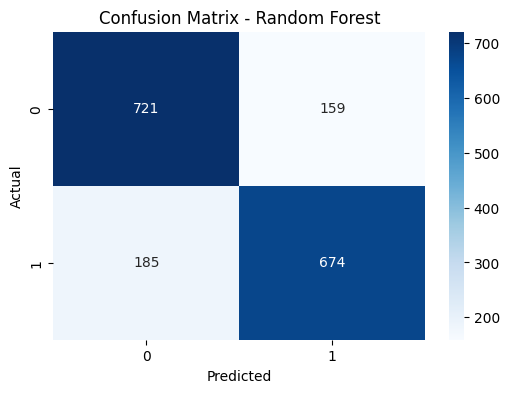

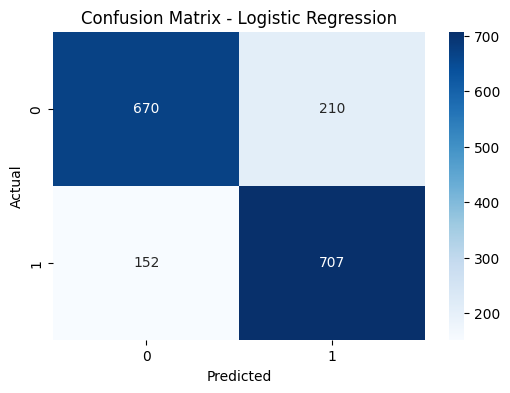

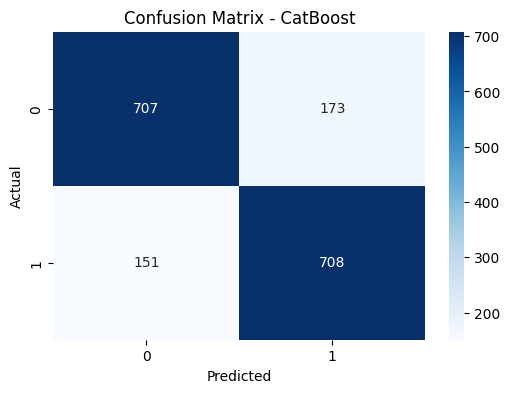

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot confusion matrix for each model
plot_confusion_matrix(y_test, predictions["Random Forest"], "Random Forest")
plot_confusion_matrix(y_test, predictions["Logistic Regression"], "Logistic Regression")
plot_confusion_matrix(y_test, predictions["CatBoost"], "CatBoost")

In [5]:
# Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf_grid = GridSearchCV(rf, rf_params, cv=5, n_jobs=-1)
rf_grid.fit(X_train, y_train)
print(rf_grid.best_params_)

{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [6]:
# Hyperparameter tuning for Logistic Regression
lr_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}
lr_grid = GridSearchCV(lr, lr_params, cv=5, n_jobs=-1, verbose=0)
lr_grid.fit(X_train, y_train)
print(lr_grid.best_params_)

[LibLinear]{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


In [7]:
# Hyperparameter tuning for CatBoost
param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 6, 9]
}
cb_grid = GridSearchCV(cb, param_grid, cv=5, n_jobs=-1, verbose=0)
cb_grid.fit(X_train, y_train)
print(cb_grid.best_params_)

{'depth': 8, 'l2_leaf_reg': 1, 'learning_rate': 0.01}


In [8]:
from sklearn.model_selection import StratifiedKFold

# Evaluate tuned models and cross-validate with 5 folds
# Create a dictionary of models
models = {
    'Random Forest': RandomForestClassifier(random_state = 13, **rf_grid.best_params_),
    'Logistic Regression': LogisticRegression(random_state = 13, **lr_grid.best_params_),
    'CatBoost': CatBoostClassifier(random_state = 13, **cb_grid.best_params_, verbose=False),
}

# Initialize the dictionaries that will be dataframes for each metric
accuracy_df = pd.DataFrame()
precision_df = pd.DataFrame()
recall_df = pd.DataFrame()
f1_df = pd.DataFrame()

# The number of splits is specified as 5
skf = StratifiedKFold(n_splits=5)

# The models are fitted through folds
for name, model in models.items():
    # Containers for each performance metric
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Performance metrics are calculated in each fold
    for train_index, test_index in skf.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)

        y_pred_fold = model.predict(X_test_fold)

        accuracy_scores.append(accuracy_score(y_test_fold, y_pred_fold))
        precision_scores.append(precision_score(y_test_fold, y_pred_fold))
        recall_scores.append(recall_score(y_test_fold, y_pred_fold))
        f1_scores.append(f1_score(y_test_fold, y_pred_fold))

    # Update the metric dataframes with the current model
    accuracy_df[name] = accuracy_scores
    precision_df[name] = precision_scores
    recall_df[name] = recall_scores
    f1_df[name] = f1_scores

print("Accuracy df")
print(accuracy_df.head())
print("\nPrecision df")
print(precision_df.head())
print("\nRecall df")
print(recall_df.head())
print("\nF1 df")
print(f1_df.head())

Accuracy df
   Random Forest  Logistic Regression  CatBoost
0       0.661875             0.780334  0.641748
1       0.734330             0.781484  0.707303
2       0.795285             0.801035  0.785509
3       0.818757             0.800345  0.793441
4       0.759494             0.779056  0.720944

Precision df
   Random Forest  Logistic Regression  CatBoost
0       0.964516             0.757829  0.992218
1       0.783562             0.751521  0.760284
2       0.774841             0.793792  0.755330
3       0.788066             0.780851  0.733273
4       0.900175             0.718611  0.977941

Recall df
   Random Forest  Logistic Regression  CatBoost
0       0.341324             0.828767  0.291096
1       0.652968             0.845890  0.611872
2       0.836758             0.817352  0.849315
3       0.875429             0.838857  0.926857
4       0.587429             0.922286  0.456000

F1 df
   Random Forest  Logistic Regression  CatBoost
0       0.504216             0.791712  0.450

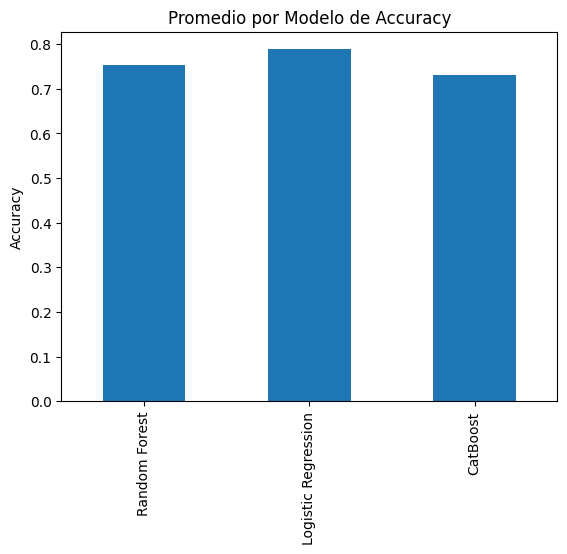

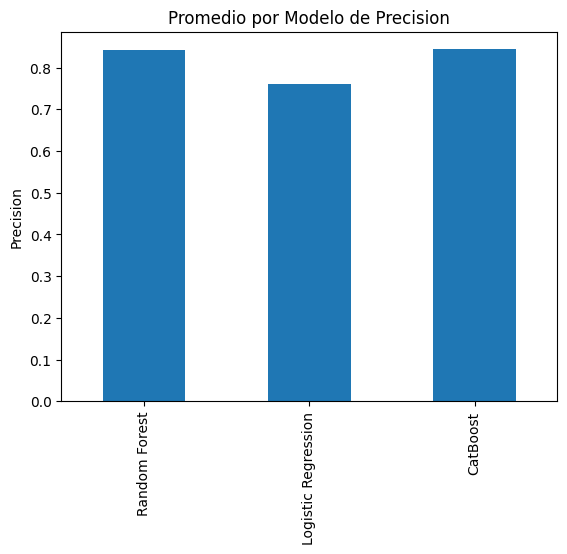

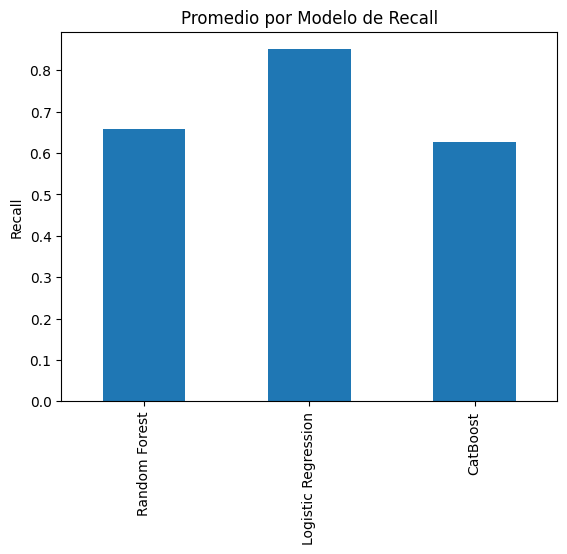

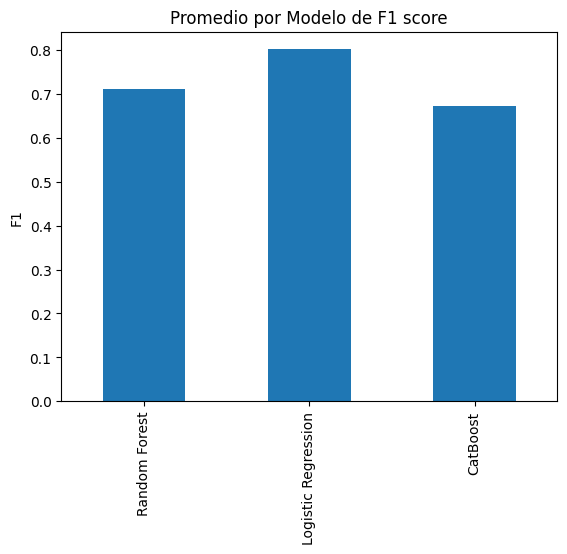

In [9]:
# Calculate means
accuracy_mean = accuracy_df.mean()
precision_mean = precision_df.mean()
recall_mean = recall_df.mean()
f1_mean = f1_df.mean()

# Visualize results
accuracy_mean.plot(kind='bar', title='Promedio por Modelo de Accuracy')
plt.ylabel('Accuracy')
plt.show()

precision_mean.plot(kind='bar', title='Promedio por Modelo de Precision')
plt.ylabel('Precision')
plt.show()

recall_mean.plot(kind='bar', title='Promedio por Modelo de Recall')
plt.ylabel('Recall')
plt.show()

f1_mean.plot(kind='bar', title='Promedio por Modelo de F1 score')
plt.ylabel('F1')
plt.show()

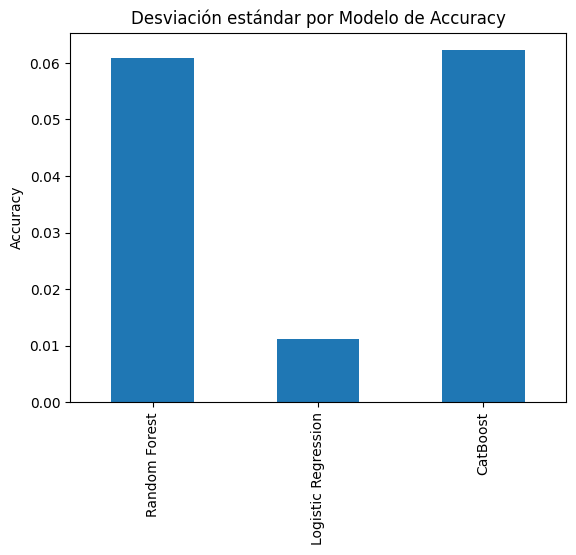

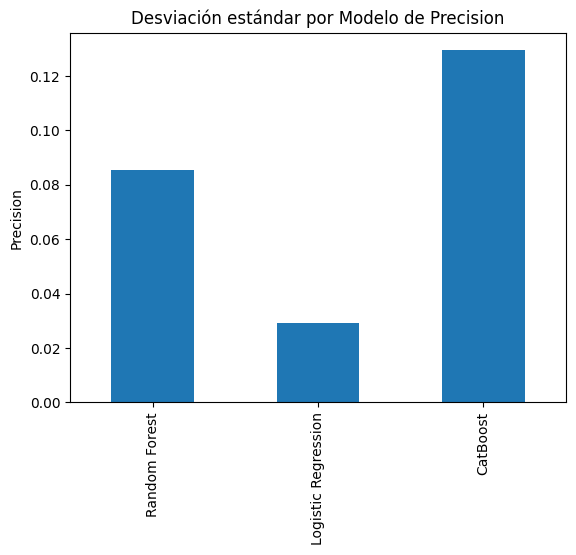

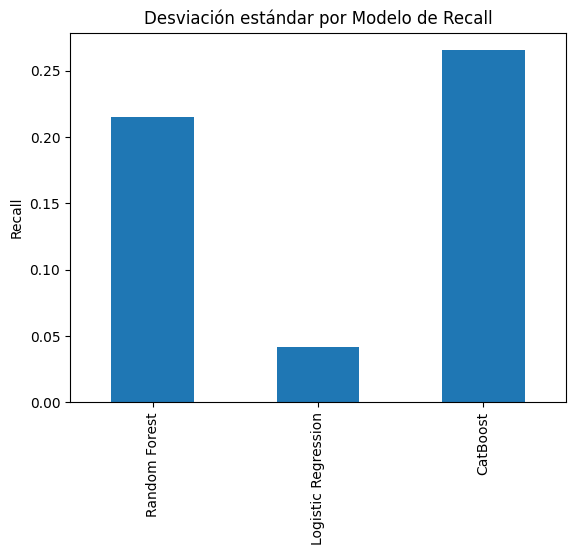

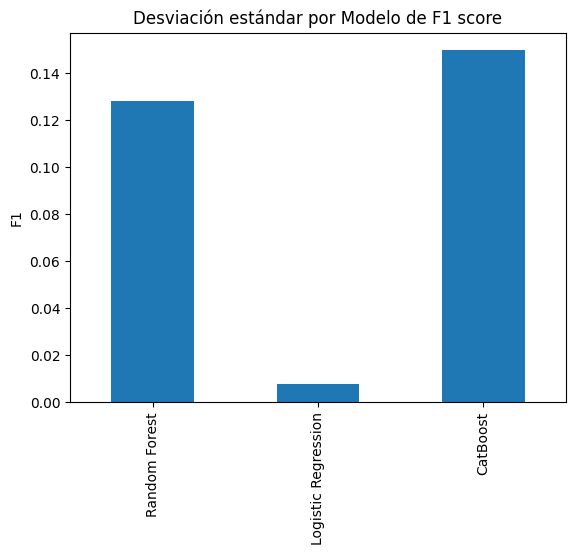

In [10]:
# Calculate standard deviation
accuracy_std = accuracy_df.std()
precision_std = precision_df.std()
recall_std = recall_df.std()
f1_std = f1_df.std()

# Visualize results
accuracy_std.plot(kind='bar', title='Desviación estándar por Modelo de Accuracy')
plt.ylabel('Accuracy')
plt.show()

precision_std.plot(kind='bar', title='Desviación estándar por Modelo de Precision')
plt.ylabel('Precision')
plt.show()

recall_std.plot(kind='bar', title='Desviación estándar por Modelo de Recall')
plt.ylabel('Recall')
plt.show()

f1_std.plot(kind='bar', title='Desviación estándar por Modelo de F1 score')
plt.ylabel('F1')
plt.show()

Comparación bayesiana entre Random Forest y Logistic Regression en Accuracy: (0.13780601585031496, 0.124939662619866, 0.7372543215298191)


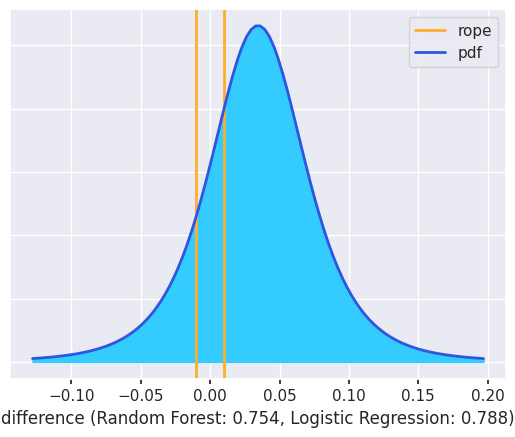

Comparación bayesiana entre Random Forest y CatBoost en Accuracy: (0.9427923880726922, 0.05305667868893682, 0.004150933238371013)


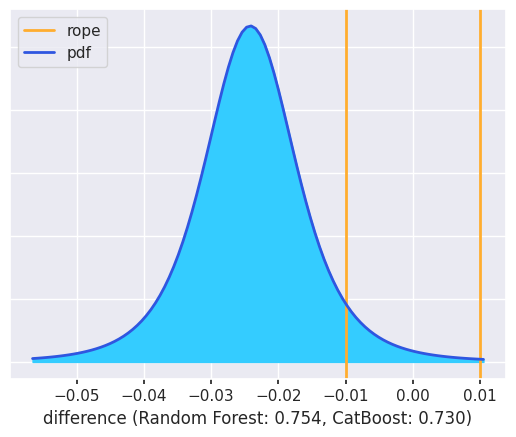

Comparación bayesiana entre Logistic Regression y CatBoost en Accuracy: (0.8791294869983376, 0.05847154241225583, 0.06239897058940658)


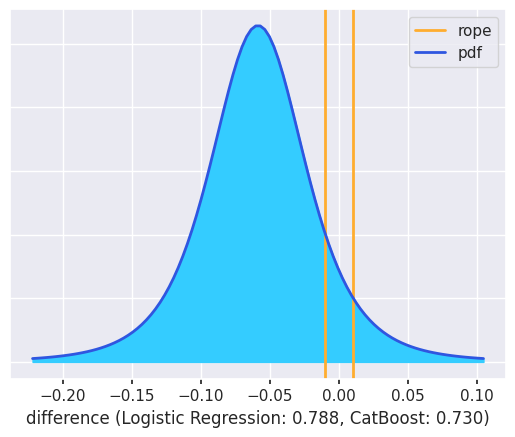

Comparación bayesiana entre Random Forest y Logistic Regression en Precision: (0.8177819187695188, 0.051638354821332166, 0.13057972640914906)


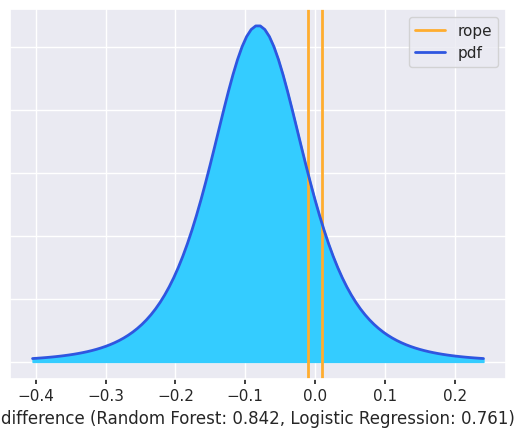

Comparación bayesiana entre Random Forest y CatBoost en Precision: (0.3778384975552414, 0.21198712636854167, 0.410174376076217)


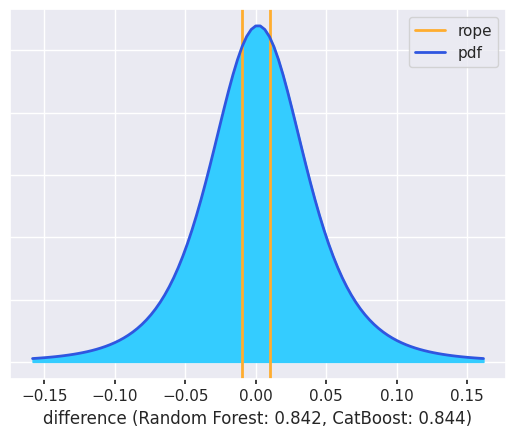

Comparación bayesiana entre Logistic Regression y CatBoost en Precision: (0.20473451507786322, 0.05010119060024476, 0.745164294321892)


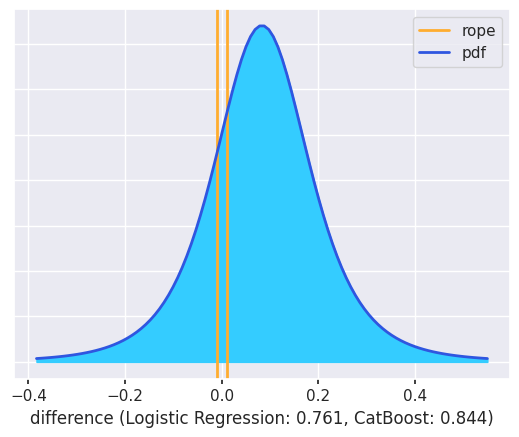

Comparación bayesiana entre Random Forest y Logistic Regression en Recall: (0.127092650449339, 0.021339900224796926, 0.851567449325864)


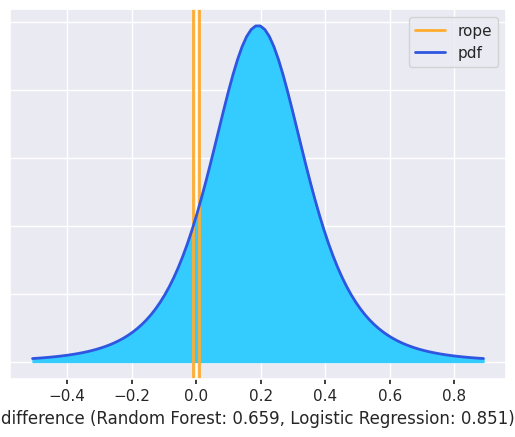

Comparación bayesiana entre Random Forest y CatBoost en Recall: (0.6677609286371811, 0.12209863205878269, 0.21014043930403625)


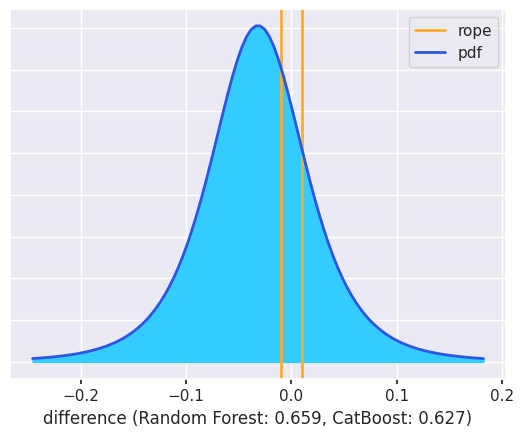

Comparación bayesiana entre Logistic Regression y CatBoost en Recall: (0.8383667424381656, 0.01877081717334883, 0.1428624403884856)


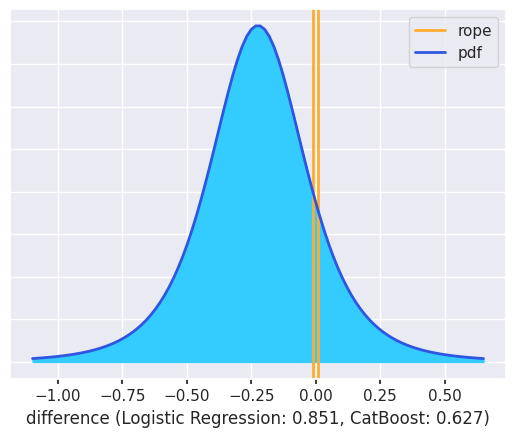

Comparación bayesiana entre Random Forest y Logistic Regression en f1 score: (0.14477072146834083, 0.04763150228940427, 0.8075977762422549)


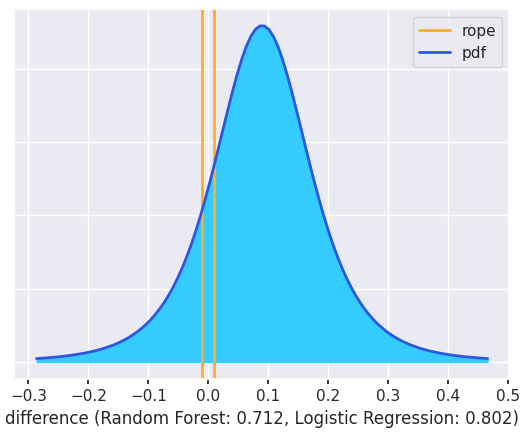

Comparación bayesiana entre Random Forest y CatBoost en f1 score: (0.8592994488646477, 0.08967949586077606, 0.05102105527457623)


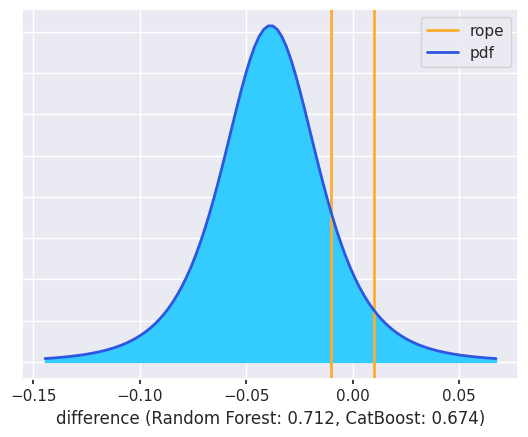

Comparación bayesiana entre Logistic Regression y CatBoost en f1 score: (0.8558300774971028, 0.03123660527688632, 0.11293331722601085)


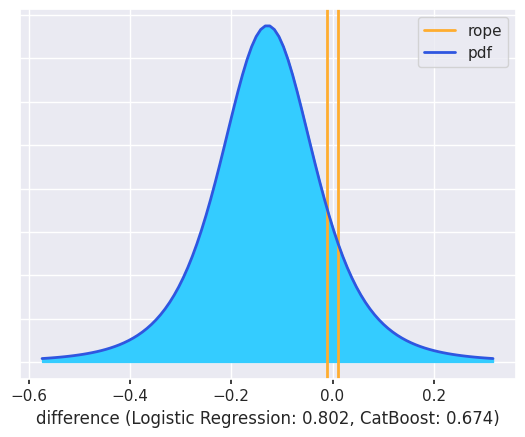

In [11]:
import baycomp

# Function to perform Bayesian comparisons between all pairs of models and generate graphs
def comparaciones_bayesianas(df, nombre_metrica):
    rope = 0.01  # Region of Practical Equivalence (ROPE)
    bayes_comparison_results = {}

    # Compare all unique pairs of models
    for i, modelo_1 in enumerate(df.columns):
        for j, modelo_2 in enumerate(df.columns):
            if i < j:  # Avoid duplicate comparisons and self-comparisons
                # Perform Bayesian comparison between the two selected models using two_on_single
                probs, fig = baycomp.two_on_single(
                    df[modelo_1].values,  # Results of the first model
                    df[modelo_2].values,  # Results of the second model
                    rope=rope,
                    plot=True,  # Generate graph
                    names=(modelo_1, modelo_2)
                )
                bayes_comparison_results[(modelo_1, modelo_2)] = probs
                print(f"Comparación bayesiana entre {modelo_1} y {modelo_2} en {nombre_metrica}: {probs}")

                plt.show()

    return bayes_comparison_results

# Bayesian comparison for each metric and generate graphics
resultados_bayesianos_mse = comparaciones_bayesianas(accuracy_df, 'Accuracy')
resultados_bayesianos_mae = comparaciones_bayesianas(precision_df, 'Precision')
resultados_bayesianos_r2 = comparaciones_bayesianas(recall_df, 'Recall')
resultados_bayesianos_rmse = comparaciones_bayesianas(f1_df, 'f1 score')

# Bayesian Analysis and Best model

As can be seen in the Bayesian comparisons and the graphs produced, in the selection of a better model for data prediction from among the 3 selected, it is clear that the least suitable model is CatBoost, showing that, despite previously showing good metrics for recall and f1, when inserting uncertainty and regularization through the Bayesian method to the model, it has a decrease in performance. Although CatBoost is not so bad in terms of accuracy, we are more interested in the recall, since we want to reduce false negatives as much as possible, since it is possible that a trip is approved wrongly and the passenger disappears. The F1 score is equally important, since we also seek to reduce false alarms as they are costly in terms of clientele and trips.

For this reason, we stay between Random Forest and Logistic Regression, since both show little significant difference in terms of their performance in the metrics of interest mentioned. To rule out one to define the best, it is not enough to observe its relationship in recall and f1, since even though Random Forest proves to be slightly better than Logistic Regression, the difference is not very relevant, so it is useful to take the CatBoost model as a common comparison, and by comparing how better each model is in relation to the aforementioned CatBoost, it will be easier to know which of the remaining 2 is better than the other. In F1, the differences with respect to CatBoost are too similar, the difference with Random Forest being slightly more relevant, however, since the difference is very small and when analyzing the recall, which can be more critical regarding passenger safety, we see that Logistic Regression is better than CatBoost in relation to Random Forest, and the relevance of improvement is also greater.

With this we can conclude that, although the performance of Random Forest and Logistic Regression is very similar, Logistic Regression shows a better performance regarding recall, and since it has a little significant difference with Random Forest, we can conclude that it is the best model for our predictions.

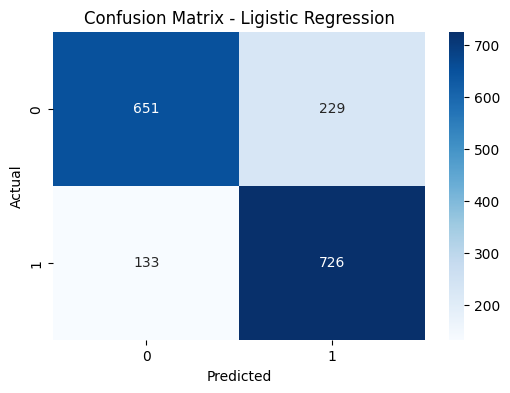

In [12]:
# Fit with the best model (Logistic Regression with tuned hyperparameters and random state 13)
best_model = LogisticRegression(random_state=13, **lr_grid.best_params_)
best_model.fit(X_train, y_train)

# Predict dataset
y_lr_pred = best_model.predict(X_test)

# plot confusion matrix
plot_confusion_matrix(y_test, y_lr_pred, "Ligistic Regression")

# Test Set

In [13]:
# Predict the test set with 100% of the data and save it as a csv
df = pd.read_csv("test.csv")

# Function to impute mean or median based on skewness
def impute_with_mean_or_median(column):
    skewness = df[column].skew()

    if abs(skewness) > 1:
        mediana = df[column].median()
        return df[column].fillna(mediana)
    
    media = round(df[column].mean())
    return df[column].fillna(media)

# Function to impute mode based on the most frequent value
def mode_impute(column):
    moda_val = df[column].mode()[0]
    return df[column].fillna(moda_val)

# Binarize the booleans
df['CryoSleep'] = df['CryoSleep'].replace({False: 0, True: 1})
df['VIP'] = df['VIP'].replace({False: 0, True: 1})
#df['Transported'] = df['Transported'].replace({False: 0, True: 1})

# I: Create new columns
# Passenger Id: Divide into group and passenger number
df[['GroupNum', 'PassNum']] = df['PassengerId'].str.split('_', expand=True)
df['GroupNum'] = pd.to_numeric(df['GroupNum'], errors='coerce')
df['PassNum'] = pd.to_numeric(df['PassNum'], errors='coerce')
df.drop(columns=["PassengerId"], inplace=True)
# TotalSpent: Total spent on amenities
df['TotalSpent'] = df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)
# Cabin column: Divide in three: Deck, CabinNumber, CabinSide
df[['Deck', 'CabinNumber', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)
df.drop(columns=["Cabin"], inplace=True)

# II: Label encoding for categorical data
df['HomePlanet'] = df['HomePlanet'].replace({'Earth': 0, 'Mars': 1, 'Europa': 2})
df['Destination'] = df['Destination'].replace({'TRAPPIST-1e': 0, '55 Cancri e': 1, 'PSO J318.5-22': 2})
df['Deck'] = df['Deck'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7})
df['CabinSide'] = df['CabinSide'].replace({'P': 0, 'S': 1})

# III: Special cases for missing categorical values
# **Deck: (6 if HomePlanet == 0 and Deck is null)
df.loc[(df['HomePlanet'] == 0) & (df['Deck'].isnull()), 'Deck'] = 6 # Deck 6 is for passengers from Earth
# **CryoSleep: (0 if TotalSpent != 0)
df.loc[(df['TotalSpent'] > 0) & (df['CryoSleep'].isnull()), 'CryoSleep'] = 0 # If a passenger has spent money, then they did not use Cryosleep
# **VIP: If CryoSleep is 1 then 0, else impute mode
df.loc[(df['CryoSleep'] == 1) & (df['VIP'].isnull()), 'VIP'] = 0 # If a passenger is in Cryosleep, then they're not VIP

# IV: Impute categorical data with mode
df['HomePlanet'] = mode_impute('HomePlanet')
df['Destination'] = mode_impute('Destination')
df['Deck'] = mode_impute('Deck')
df['CabinSide'] = mode_impute('CabinSide')
df['CryoSleep'] = mode_impute('CryoSleep')
df['VIP'] = mode_impute('VIP')

# V: Create interaction columns
# HomePlanet-Destination: Bin the HomePlanet and Destination columns
df['HomePlanet_Destination_Interaction'] = df['HomePlanet'] * df['Destination']
# Deck-Cabin

# VI: Special cases for missing numerical values
# **Amennities: (0 if CryoSleep == 1)
amenities = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
for amenity in amenities:
    df.loc[(df['CryoSleep'] == 1) & (df[amenity].isnull()), amenity] = 0 # If a passenger is in Cryosleep, then they did not use any amenities
# **Age: (6 if TotalSpent == 0)
df.loc[(df['TotalSpent'] == 0) & (df['Age'].isnull()), 'Age'] = 6 # If a passenger has not spent any money, then they're likely a child. 6 is the mean age of non-spdender children

# VII: Impute numerical data with mean or median
df['RoomService'] = impute_with_mean_or_median('RoomService')
df['FoodCourt'] = impute_with_mean_or_median('FoodCourt')
df['ShoppingMall'] = impute_with_mean_or_median('ShoppingMall')
df['Spa'] = impute_with_mean_or_median('Spa')
df['VRDeck'] = impute_with_mean_or_median('VRDeck')
df['CabinNumber'] = pd.to_numeric(df['CabinNumber'], errors='coerce') # Convert CabinNumber to numeric
df['CabinNumber'] = impute_with_mean_or_median('CabinNumber')
df['Age'] = impute_with_mean_or_median('Age')

# VIII: Drop unnecessary columns
df.drop(columns=["Name"], inplace=True)

# IX: Standarize the data
# The dataset is standardized
df_standardized = (df - df.mean()) / df.std()

# Ensure all columns are numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Save cleaned dataset as csv | Optional
df.to_csv('clean.csv', index=False)

In [14]:
# Model training and csv submission (Create Transported column and predict using the best model)
best_model.fit(X, y)
y_pred = best_model.predict(df)
#y_pred = svm_best.predict(df)
#y_pred = lgbm_best.predict(df)

# Generate submission csv with PassengerId (once removed for data cleaning) and Transported columns only
submission = pd.read_csv("test.csv")
submission['Transported'] = y_pred
submission = submission[['PassengerId', 'Transported']]
# Transform boolean values to strings
submission['Transported'] = submission['Transported'].replace({0: 'False', 1: 'True'})
submission.to_csv('submission.csv', index=False)

In [15]:
#Store model using pickle
import pickle
filename = 'finalized_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

In [16]:
# Loading process for the model in pickle file

"""
#Load the model from disk (Pickle) - Section to get csv submission
import pandas as pd 
import pickle
submission = pd.read_csv("test.csv")
testset = df # Processed test set
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
# Evaluate train set
y_pred = loaded_model.predict(testset)
submission['Transported'] = y_pred
submission = submission[['PassengerId', 'Transported']]
submission['Transported'] = submission['Transported'].replace({0: 'False', 1: 'True'})

# Save submission as csv
submission.to_csv('submission2.csv', index=False)

"""

'\n#Load the model from disk (Pickle) - Section to get csv submission\nimport pandas as pd \nimport pickle\nsubmission = pd.read_csv("test.csv")\ntestset = df # Processed test set\nfilename = \'finalized_model.sav\'\nloaded_model = pickle.load(open(filename, \'rb\'))\n# Evaluate train set\ny_pred = loaded_model.predict(testset)\nsubmission[\'Transported\'] = y_pred\nsubmission = submission[[\'PassengerId\', \'Transported\']]\nsubmission[\'Transported\'] = submission[\'Transported\'].replace({0: \'False\', 1: \'True\'})\n\n# Save submission as csv\nsubmission.to_csv(\'submission2.csv\', index=False)\n\n'